In [12]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.utils import Sequence
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, concatenate)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG, Audio
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [13]:
datasetPath = "../../datasets_mod"

In [14]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

# Split Into Training and Testing
directory0 = f"{datasetPath}/spectrograms3sec/train/"
directory1 = f"{datasetPath}/mfccs3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrograms3sec/test/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory0,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:

      shutil.move(directory0 + f"{g}"+ "/" + f,f"{datasetPath}/spectrograms3sec/test/" + f"{g}")
      shutil.move(directory1 + f"{g}"+ "/" + f,f"{datasetPath}/mfccs3sec/test/" + f"{g}")

# Split Into Training and Validation
directory0 = f"{datasetPath}/spectrograms3sec/train/"
directory1 = f"{datasetPath}/mfccs3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrograms3sec/valid/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory0,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:

      shutil.move(directory0 + f"{g}"+ "/" + f,f"{datasetPath}/spectrograms3sec/valid/" + f"{g}")
      shutil.move(directory1 + f"{g}"+ "/" + f,f"{datasetPath}/mfccs3sec/valid/" + f"{g}")

In [15]:
train0_dir = f"{datasetPath}/spectrograms3sec/train/"
train0_datagen = ImageDataGenerator(rescale=1./255)
train0_generator = train0_datagen.flow_from_directory(train0_dir,target_size=(26,65),color_mode="rgba",class_mode='categorical',batch_size=128)

test0_dir = f"{datasetPath}/spectrograms3sec/test/"
test0_datagen = ImageDataGenerator(rescale=1./255)
test0_generator = test0_datagen.flow_from_directory(test0_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

validation0_dir = f"{datasetPath}/spectrograms3sec/valid/"
vali0_datagen = ImageDataGenerator(rescale=1./255)
vali0_generator = vali0_datagen.flow_from_directory(validation0_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [16]:
train1_dir = f"{datasetPath}/mfccs3sec/train/"
train1_datagen = ImageDataGenerator(rescale=1./255)
train1_generator = train0_datagen.flow_from_directory(train0_dir,target_size=(26,65),color_mode="rgba",class_mode='categorical',batch_size=128)

test1_dir = f"{datasetPath}/mfccs3sec/test/"
test1_datagen = ImageDataGenerator(rescale=1./255)
test1_generator = test0_datagen.flow_from_directory(test0_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

validation1_dir = f"{datasetPath}/mfccs3sec/valid/"
vali1_datagen = ImageDataGenerator(rescale=1./255)
vali1_generator = vali0_datagen.flow_from_directory(validation0_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [17]:
class CombinedGenerator(Sequence):
    def __init__(self, generator1, generator2):
        self.generator1 = generator1
        self.generator2 = generator2
        
    def __len__(self):
        return len(self.generator1)
    
    def __getitem__(self, index):
        X1, Y1 = self.generator1[index]
        X2, Y2 = self.generator2[index]
        
        return [X1, X2], Y1

In [18]:
train_data = CombinedGenerator(train0_generator, train1_generator)
val_data = CombinedGenerator(vali0_generator, vali1_generator)
test_data = CombinedGenerator(test0_generator, test1_generator)

In [19]:
def GenreModel(spect_shape = (26,65, 4),mfcc_shape = (26,65, 4), classes=10):
  
  X0_input = Input(spect_shape)
  X1_input = Input(mfcc_shape)

  X0 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X0_input)
  X0 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X0)
  X0 = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X0)
  X0 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X0)
  X0 = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X0)
  X0 = Conv2D(512, kernel_size=(4,4), activation='relu',padding="valid")(X0)
  X0 = GlobalAveragePooling2D()(X0)
  
  # define convolutional layers for MFCC input
  X1 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X1_input)
  X1 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X1)
  X1 = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X1)
  X1 = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X1)
  X1 = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X1)
  X1 = Conv2D(512, kernel_size=(4,4), activation='relu',padding="valid")(X1)
  X1 = GlobalAveragePooling2D()(X1)
  
  concat = concatenate([X0, X1])
  
  Y = Dense(256, activation='relu')(concat)
  Y = Dense(128, activation='relu')(Y)
  Y = Dense(10, activation='softmax')(Y)

  model = Model(inputs=[X0_input, X1_input],outputs=Y,name='GenreModel')

  return model

In [20]:
# checkpoint_path = "saved_cnn3/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=False,
#                                                 verbose=1)

model = GenreModel(spect_shape = (26,65, 4),mfcc_shape = (26,65, 4), classes=10)
opt = Adam()
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

Model: "GenreModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 26, 65, 4)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 26, 65, 4)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 24, 63, 256)  9472        ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 24, 63, 256)  9472        ['input_4[0][0]']                
                                                                                         

In [22]:
fresh_model = True

from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint("saved/saved_cnn17_3.hdf5", save_best_only=True, monitor="val_loss", mode="min")
model_history = model.fit_generator(train_data,epochs=80,validation_data=val_data, callbacks=[mc])

# if os.path.exists("../saved/saved_cnn16_3.h5"):
#     model_history = keras.models.load_model("../saved/saved_cnn16_3.h5")
# else:
#     model_history = model.fit_generator(train_generator,epochs=200,validation_data=vali_generator)
#     # model.save("../saved/saved_cnn16_3.h5")
#     fresh_model = True


/tmp/ipykernel_113376/2160069670.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_data,epochs=80,validation_data=val_data, callbacks=[mc])


Epoch 1/80
63/63 [==============================] - 61s 965ms/step - loss: 2.0867 - accuracy: 0.2161 - val_loss: 1.8750 - val_accuracy: 0.3130
Epoch 2/80
63/63 [==============================] - 58s 919ms/step - loss: 1.8560 - accuracy: 0.3111 - val_loss: 1.7389 - val_accuracy: 0.3780
Epoch 3/80
63/63 [==============================] - 58s 916ms/step - loss: 1.7149 - accuracy: 0.3668 - val_loss: 1.6149 - val_accuracy: 0.4070
Epoch 4/80
63/63 [==============================] - 58s 912ms/step - loss: 1.6018 - accuracy: 0.4045 - val_loss: 1.6448 - val_accuracy: 0.3560
Epoch 5/80
63/63 [==============================] - 58s 911ms/step - loss: 1.4846 - accuracy: 0.4486 - val_loss: 1.4012 - val_accuracy: 0.4660
Epoch 6/80
63/63 [==============================] - 58s 914ms/step - loss: 1.4060 - accuracy: 0.4785 - val_loss: 1.5421 - val_accuracy: 0.4350
Epoch 7/80
63/63 [==============================] - 58s 912ms/step - loss: 1.3675 - accuracy: 0.4919 - val_loss: 1.4256 - val_accuracy: 0.4690

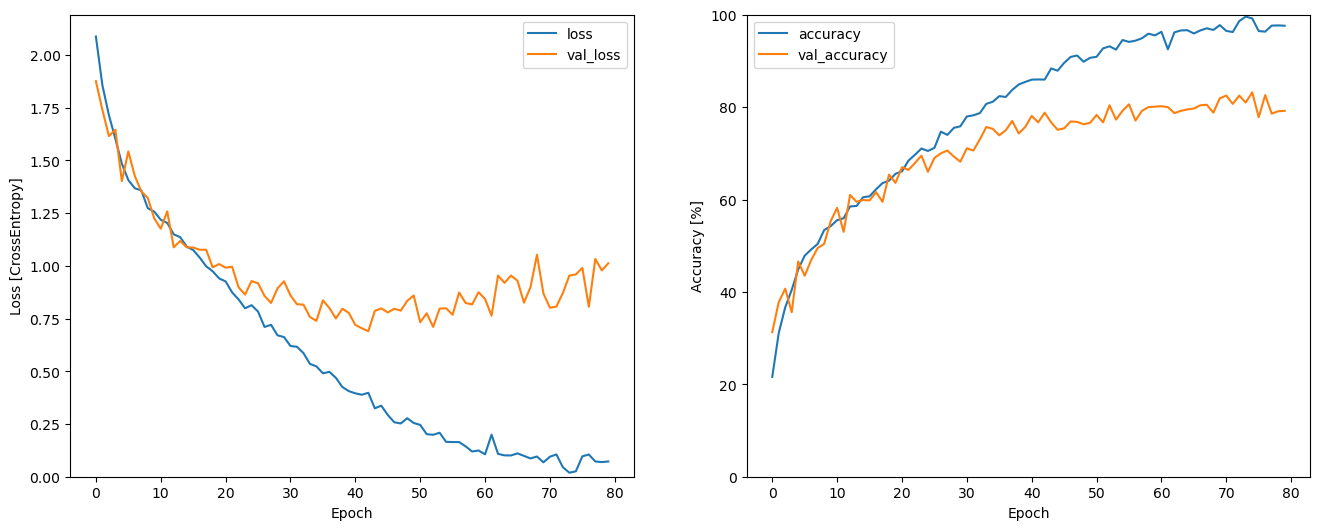

In [23]:
if fresh_model:
    metrics = model_history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(model_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')